# Notebook to make Fig. 4

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import imageio
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

### Load data

In [1]:
## TODO: finalize this with the real output dir
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

angles_vs_time_dict =  np.load(data_dir+'angles_vs_time_dict.npy', allow_pickle=True).item()

In [2]:
# Reconstruction dict has the posterior values stored in it 
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_L1.npy",allow_pickle=True).item()

### Make figure

Zoom in on a couple of times of interest ($t=-40M$ and $t=-10M$)

In [3]:
# Define some things for plotting
colors = ['blue', 'red']

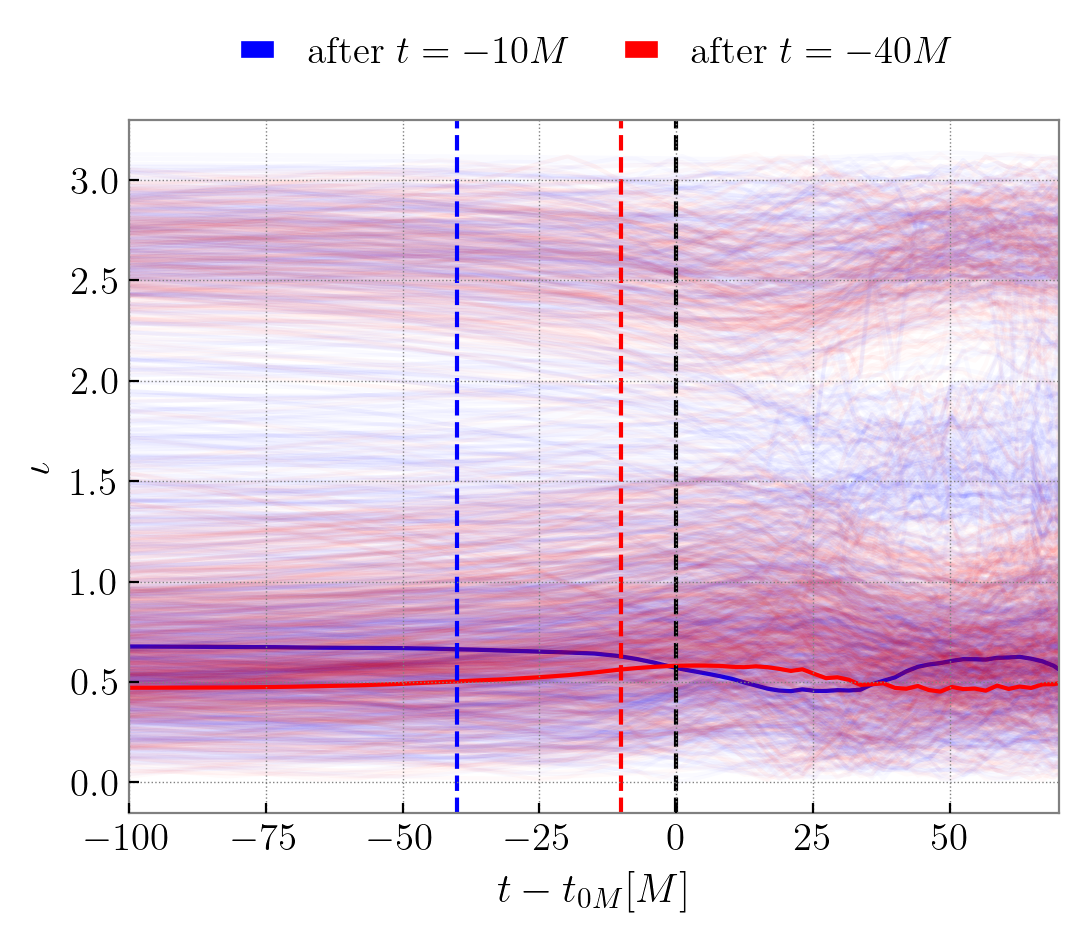

In [12]:
# Make figure
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500

fig, axes = plt.subplots(1, 1)

handles = []

for i,tc in enumerate(times_to_plot): 
    
    # plot all traces
    iota_vs_time = np.asarray(angles_vs_time_dict[f'rd {tc}']['incl_vs_time'])
    time = np.asarray(angles_vs_time_dict[f'rd {tc}']['time_M'])
    axes.plot(time.T, iota_vs_time.T, color=colors[i], alpha=0.02, zorder=0)
    
    # plot maxP trace 
    imax = np.argmax(reconstruction_dict[f'rd {tc}']['params']['ln_posterior'])
    axes.plot(time[imax,:], iota_vs_time[imax,:], color=colors[i], alpha=1, zorder=0)
    
    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors[i],label=f'after $t = {lbl}$'))
    
axes.axvline(0, ls='--', color='k')
axes.axvline(-40, ls='--', color=colors[0])
axes.axvline(-10, ls='--', color=colors[1])

axes.set_xlim(-100, 70)
axes.set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes.set_ylabel(r'$\iota$', fontsize=15)

axes.legend(handles=handles, fontsize=14, bbox_to_anchor=(0.1, 1.05, 0.8, .102), 
               loc='lower left', ncols=2, mode="expand", borderaxespad=0., frameon=False)

#plt.savefig('figure_04.pdf', bbox_inches='tight')
plt.show()

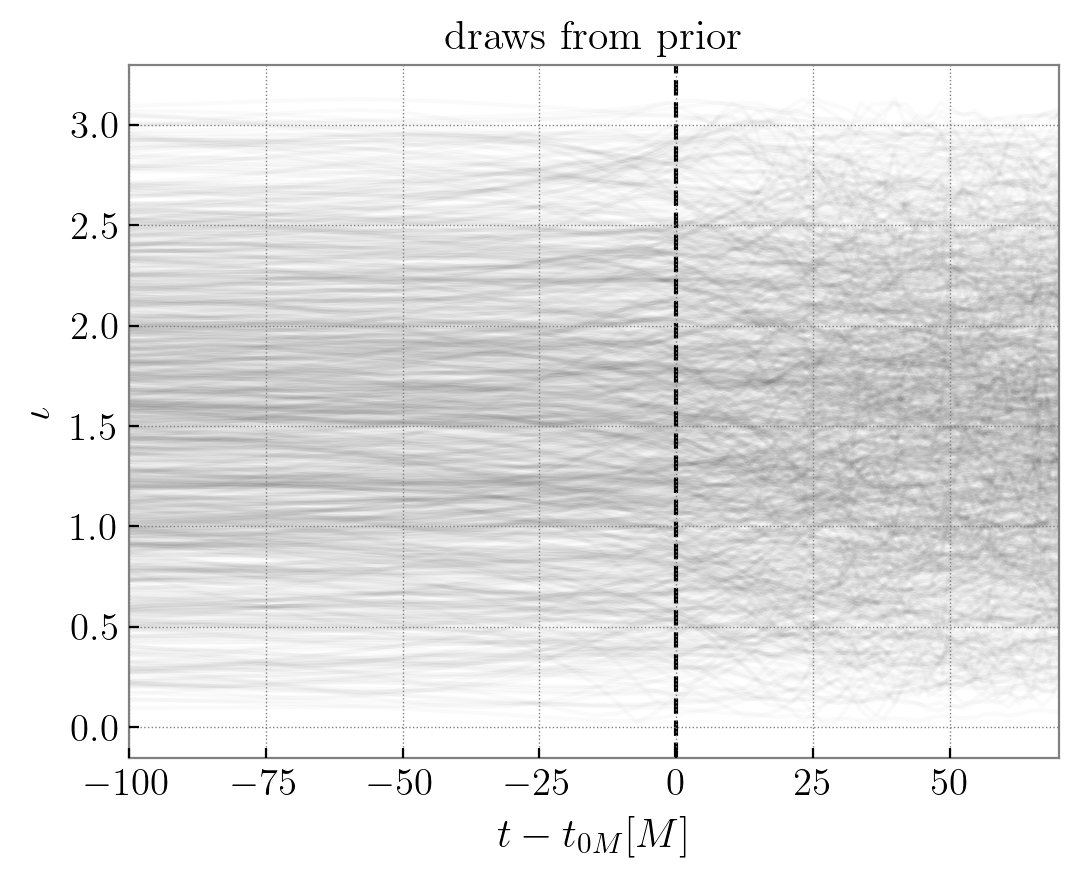

In [10]:
# plot prior 

fig, axes = plt.subplots(1, 1)

iota_vs_time = np.asarray(angles_vs_time_dict[f'prior']['incl_vs_time'])
time = np.asarray(angles_vs_time_dict[f'prior']['time_M'])
axes.plot(time.T, iota_vs_time.T, color='k', alpha=0.02, zorder=0)

axes.axvline(0, ls='--', color='k')

axes.set_xlim(-100, 70)
axes.set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes.set_ylabel(r'$\iota$', fontsize=15)

axes.set_title('draws from prior', fontsize=15)
plt.show()

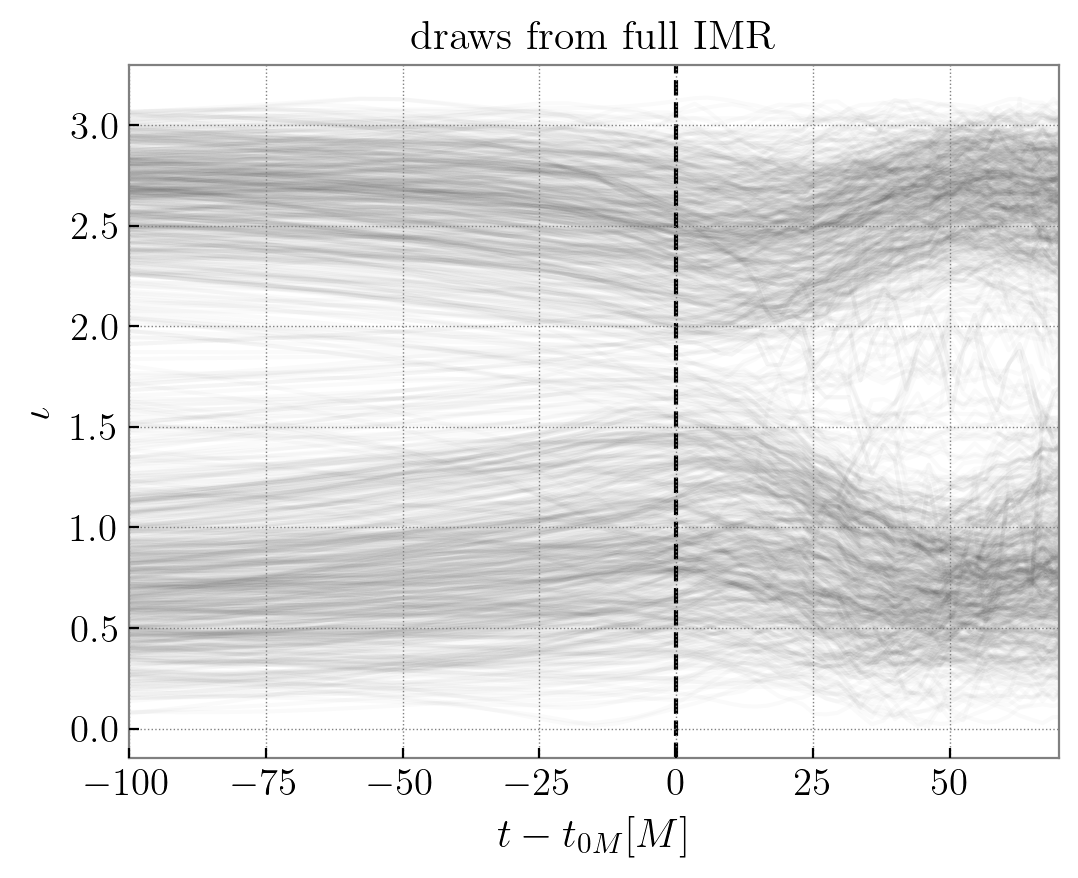

In [9]:
# plot full IMR 

fig, axes = plt.subplots(1, 1)

iota_vs_time = np.asarray(angles_vs_time_dict['full']['incl_vs_time'])
time = np.asarray(angles_vs_time_dict['full']['time_M'])
axes.plot(time.T, iota_vs_time.T, color='k', alpha=0.02, zorder=0)

axes.axvline(0, ls='--', color='k')

axes.set_xlim(-100, 70)
axes.set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes.set_ylabel(r'$\iota$', fontsize=15)

axes.set_title('draws from full IMR', fontsize=15)
plt.show()

In [7]:
p = '../data_simonas_laptop/051623_test_fixed_time_and_skypos_prior.dat'
prior_samples = np.genfromtxt(p, names=True, dtype=float)

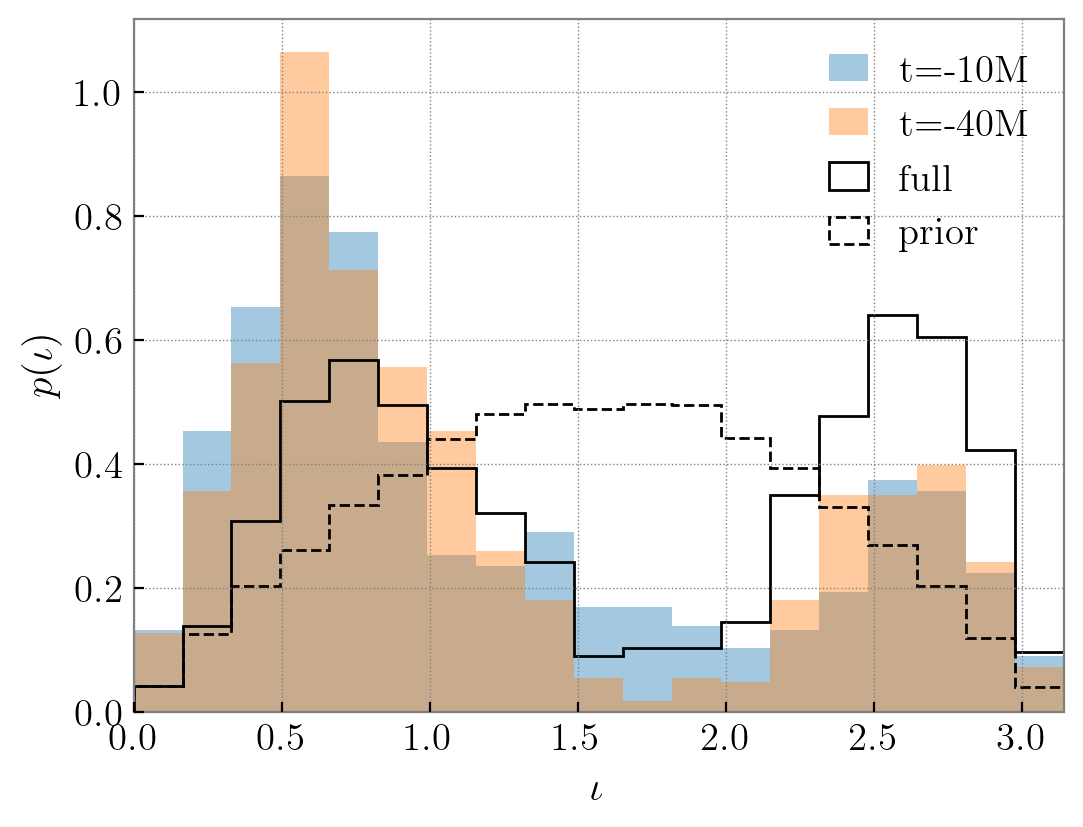

In [8]:
iota_bins = np.linspace(0, np.pi, 20)
plt.figure()
plt.hist(reconstruction_dict['rd m10M']['params']['iota'], alpha=0.4, bins=iota_bins, label='t=-10M', density=True)
plt.hist(reconstruction_dict['rd m40M']['params']['iota'], alpha=0.4, bins=iota_bins, label='t=-40M', density=True)
plt.hist(reconstruction_dict['full']['params']['iota'], color='k', histtype='step',
         bins=iota_bins, label='full', density=True)
plt.hist(prior_samples['iota'], color='k', ls='--', histtype='step', bins=iota_bins, label='prior', density=True)
plt.legend()
plt.xlabel(r'$\iota$', fontsize=15)
plt.ylabel(r'$p(\iota)$', fontsize=15)

plt.xlim(0, np.pi)
plt.show()

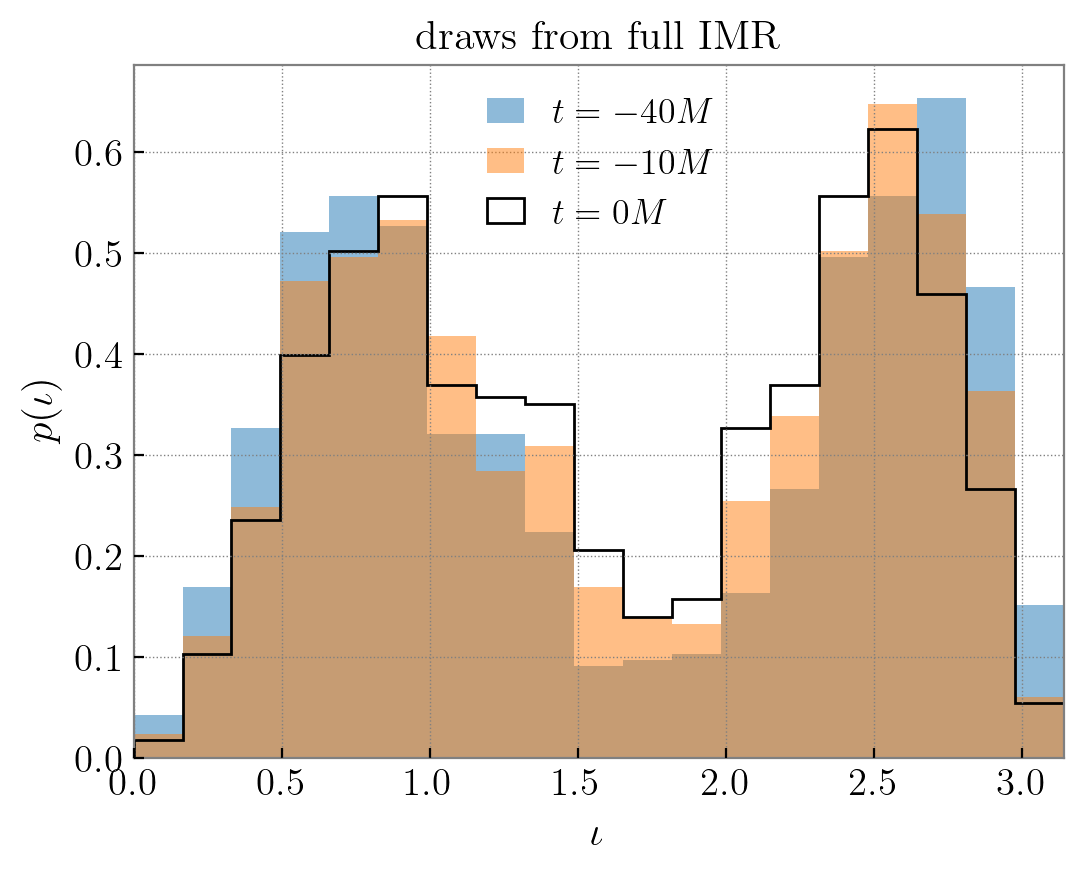

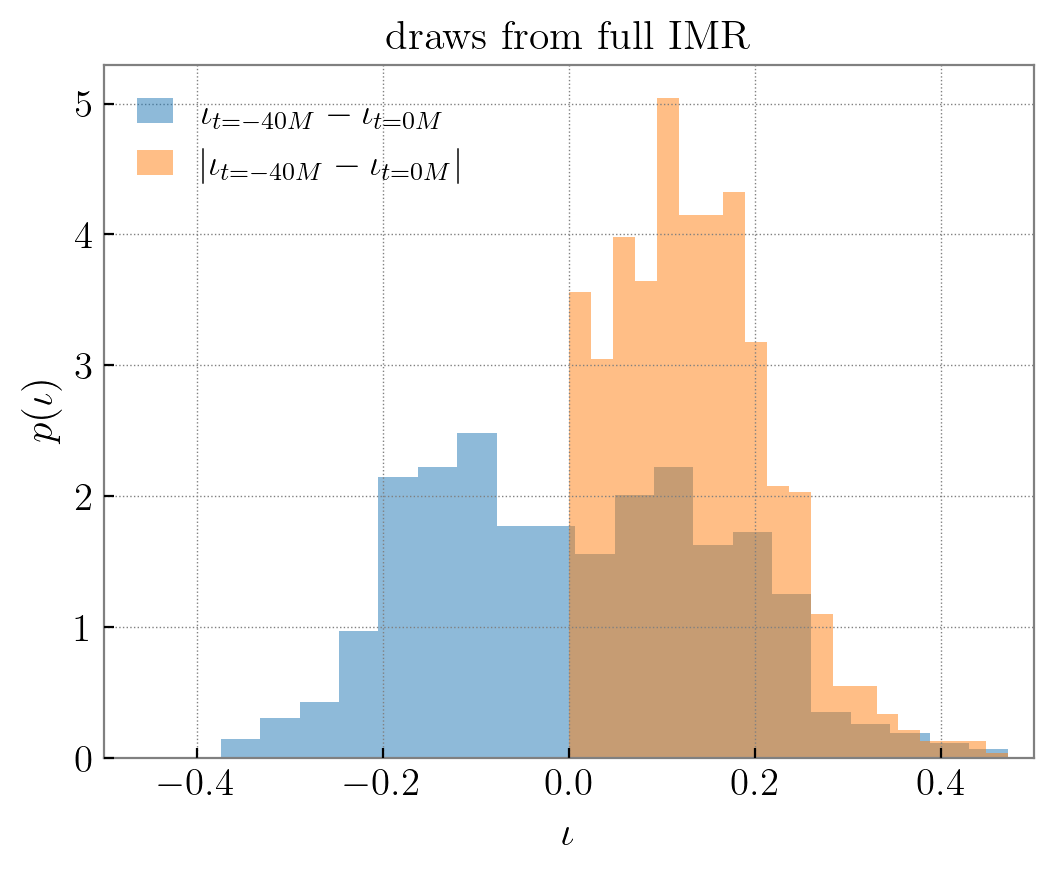

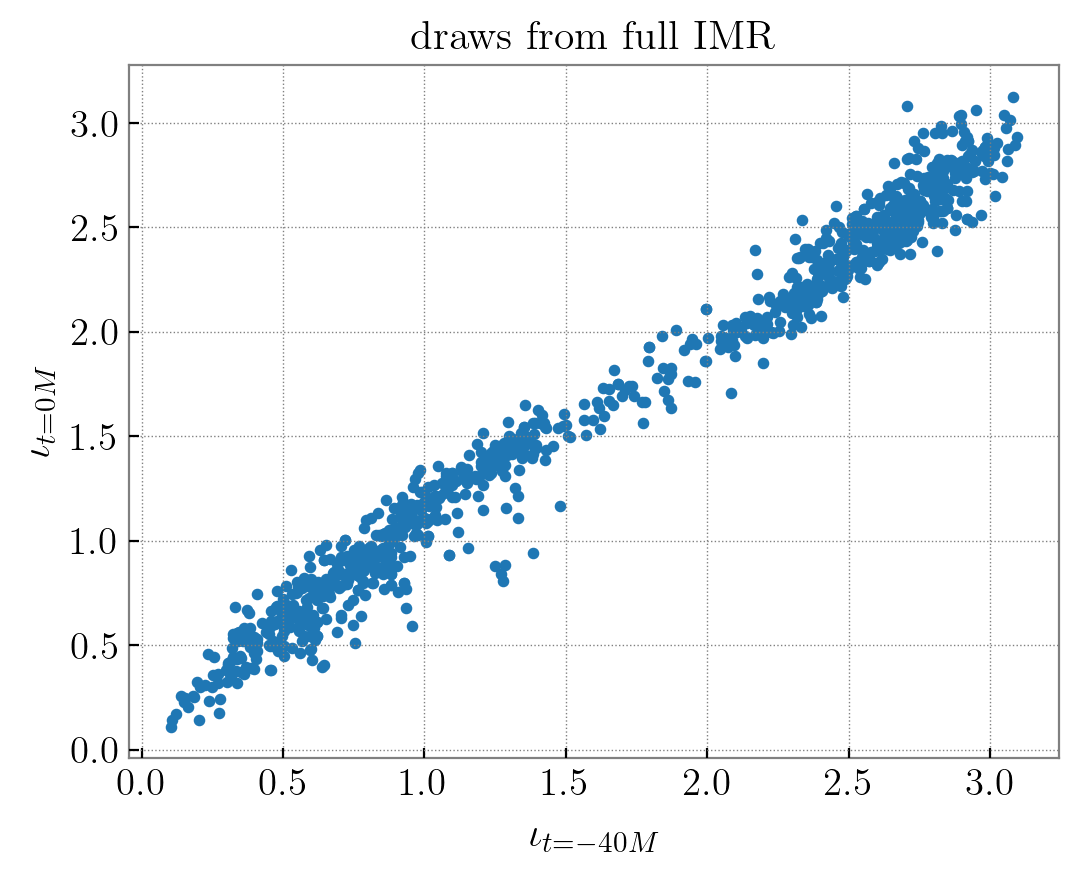

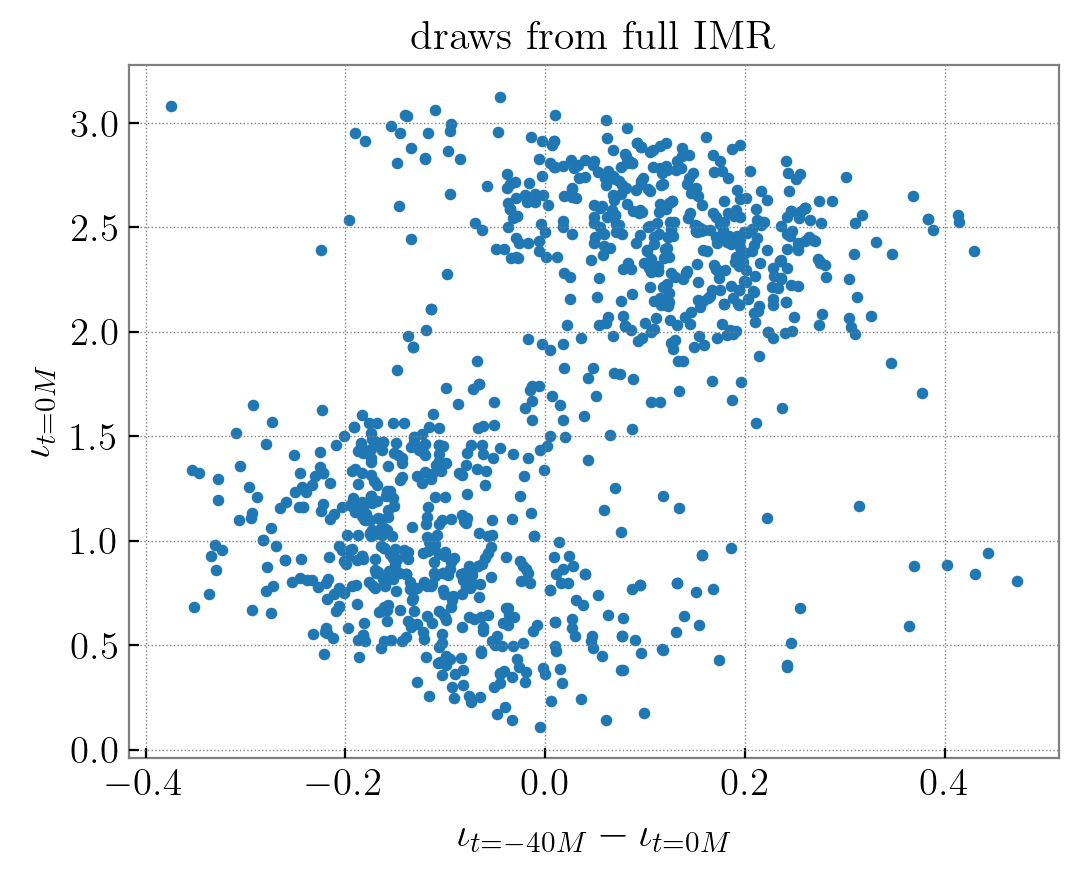

In [52]:
# iota at different times
iota_vs_time = np.asarray(angles_vs_time_dict['full']['incl_vs_time'])
time = np.asarray(angles_vs_time_dict['full']['time_M'])

iota_m40_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]+40))]
iota_m10_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]+10))]
iota_0_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]))]

iota_bins = np.linspace(0, np.pi, 20)
kws = dict(bins=iota_bins, density=True)

plt.figure()
plt.hist(iota_m40_posterior, **kws, alpha=0.5, label='$t=-40M$')
plt.hist(iota_m10_posterior, **kws, alpha=0.5, label='$t=-10M$')
plt.hist(iota_0_posterior, **kws, color='k',  histtype='step', label='$t=0M$')
plt.xlim(0, np.pi)
plt.legend(fontsize=13)
plt.xlabel(r'$\iota$', fontsize=15)
plt.ylabel(r'$p(\iota)$', fontsize=15)
plt.title('draws from full IMR', fontsize=15)
plt.show()


plt.figure()
plt.hist(iota_m40_posterior - iota_0_posterior, 
         label='$ \iota_{t=-40M} - \iota_{t=0M}$', bins=20, alpha=0.5, density=True)
plt.hist(np.abs(iota_m40_posterior - iota_0_posterior), 
         label='$| \iota_{t=-40M} - \iota_{t=0M} |$', bins=20, alpha=0.5, density=True)
plt.xlim(-0.5, 0.5)
plt.legend(fontsize=13)
plt.xlabel(r'$\iota$', fontsize=15)
plt.ylabel(r'$p(\iota)$', fontsize=15)
plt.title('draws from full IMR', fontsize=15)
plt.show()

plt.figure()
plt.scatter(iota_m40_posterior, iota_0_posterior, s=10)
plt.xlabel(r'$\iota_{t=-40M}$', fontsize=15)
plt.ylabel(r'$\iota_{t=0M}$', fontsize=15)
plt.title('draws from full IMR', fontsize=15)
plt.show()


plt.figure()
plt.scatter(iota_m40_posterior-iota_0_posterior, iota_0_posterior, s=10)
plt.xlabel(r'$\iota_{t=-40M} - \iota_{t=0M}$', fontsize=15)
plt.ylabel(r'$\iota_{t=0M}$', fontsize=15)
plt.title('draws from full IMR', fontsize=15)
plt.show()

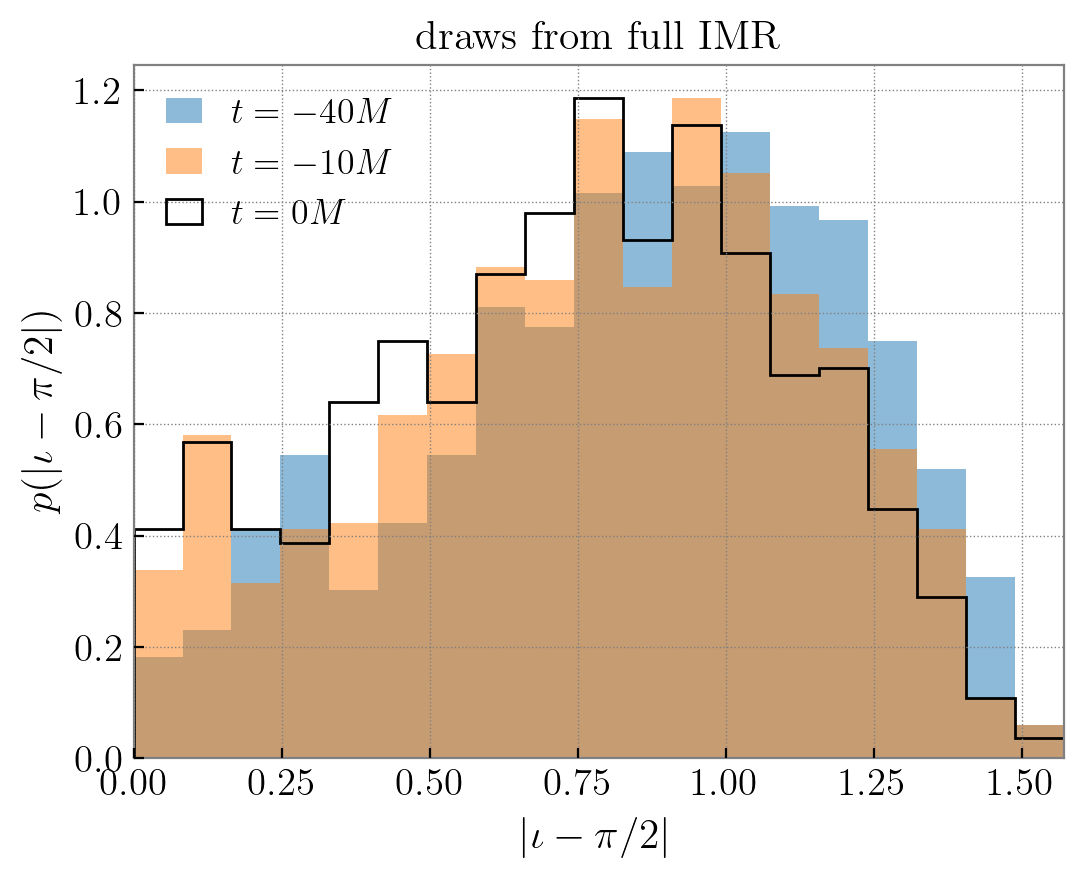

In [57]:
# iota at different times
iota_vs_time = np.asarray(angles_vs_time_dict['full']['incl_vs_time'])
time = np.asarray(angles_vs_time_dict['full']['time_M'])

iota_m40_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]+40))]
iota_m10_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]+10))]
iota_0_posterior = iota_vs_time[:,np.argmin(np.abs(time[0,:]))]

iota_bins = np.linspace(0, np.pi/2, 20)
kws = dict(bins=iota_bins, density=True)

plt.figure()
plt.hist(np.abs(iota_m40_posterior-np.pi/2), **kws, alpha=0.5, label='$t=-40M$')
plt.hist(np.abs(iota_m10_posterior-np.pi/2), **kws, alpha=0.5, label='$t=-10M$')
plt.hist(np.abs(iota_0_posterior-np.pi/2), **kws, color='k',  histtype='step', label='$t=0M$')
plt.xlim(iota_bins[0], iota_bins[-1])
plt.legend(fontsize=13)
plt.xlabel(r'$|\iota - \pi/2|$', fontsize=15)
plt.ylabel(r'$p(|\iota - \pi/2|)$', fontsize=15)
plt.title('draws from full IMR', fontsize=15)
plt.show()